In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import logging
from numpy import convolve
from matplotlib.gridspec import GridSpec
import bilby
import time as timer
from scipy import signal
global fch1,bwchan,nchan,ftop,fcentre
from astropy import units as u
MIN_FLOAT = sys.float_info[3]
fch1=1464 ## Fch1 1104 MHz
bwchan=-1## bwchan 1 MHz
nchan=336## nchan=336
ftop=fch1/1000 ##GHz
fcentre=(fch1+bwchan*nchan/2)/1000 ##GHz
print("fch1,bwchan(MHz),nchan,ftop,fcentre")
print(fch1,bwchan,nchan,ftop,fcentre,fch1+bwchan*336)

18:03 bilby INFO    : Running bilby version: 0.5.3:


fch1,bwchan(MHz),nchan,ftop,fcentre
1464 -1 336 1.464 1.296 1128


In [2]:

### write the bilby and plotting functions here
def sample_file(out,time,ydata,simpoints):
    ## make 8 band plots here
    band_check8(out,time,ydata)
    likelihood = bilby.core.likelihood.GaussianLikelihood(x=time, y=ydata,func=scat_smear_8band, sigma=None)
    result = bilby.sampler.run_sampler(likelihood=likelihood, priors=priors1,sampler='dynesty'
                                       ,npoints=simpoints,clean=True,dlogz=0.1,outdir='outdir',label=out)
    return result

def band_check8(o,time,ydata):
    plt.figure(figsize=(9,10))
    for i in range(8):
        plt.subplot(4,2,i+1)
        plt.plot(time,ydata[i],label="band "+"{0:.3f}".format(freq[i])+"GHz")
        #plt.plot(time,np.ones(len(time))*0.02,linestyle="--",label="rms from dynesty")
        plt.legend()
        plt.ylabel('S/N ($\sigma$)')
        plt.xlabel('Time (ns)')
    plt.tight_layout()
    plt.savefig(o+"_p1_subbands.png",dpi=300)
    #plt.show()
    plt.close()

def check_results(time,ydata,result,out):
    triple=result.posterior
    plotrange=[]
    #histograms=[]
    adjust=0.5
    for i in triple.values.T:
        delta=i.max()-i.min()
        plotrange.append([i.min()-delta/100,i.max()+delta/100])
        #histograms.append(data[0])
    plotrange[0][0]-=adjust
    plotrange[0][1]+=adjust
    plotrange[1][0]-=0.01
    plotrange[1][1]+=0.01
    #plotrange[2][0]-=adjust
    #plotrange[2][1]+=adjust
    values_toplot=triple.median()
    result.plot_corner(parameters=['t0','tau1','a1','a2','a3','a4','a5','a6','a7','a8','dmerr','sigi','alpha','sigma'],
                       priors=priors1,filename=out+'_posterior.png',range=plotrange[:-2],
                      save=True)
    plt.show()
    print(values_toplot)
    t0,tau1,a1,a2,a3,a4,a5,a6,a7,a8,dmerr,sigi,alpha,sigma=values_toplot[:-2]
    y=scat_smear_8band(time,t0,tau1,a1,a2,a3,a4,a5,a6,a7,a8,dmerr,sigi,alpha)
    plot_residual(time,y,ydata,sigma,out)

def plot_residual(time,y,ydata,sigma,figname="test_"):

    gs=GridSpec(3*2,4)
    #gs.update(left=0.2, right=0.85, wspace=0.05,top=0.99,bottom=0.08)
    fig=plt.figure(figsize=(16,8))
    #olor_range=["red","blue","black","green"]
    for i in range(len(y)):
        #print(i,(i//4*3),(2+i//4*3),i%4)
        t1,t2=(i//4*3),(2+i//4*3)
        ax1=fig.add_subplot(gs[t1:t2,i%4])
        ax1.plot(time,y[i],color='black')
        ax1.set_ylabel("S/N ($\sigma$)")
        ax1.errorbar(time,ydata[i],yerr=sigma,fmt='o',ms=2,label="{0:.3f}".format(freq[i])+"GHz",color="black")
        plt.legend()
    #gs.update(wspace=0.5, hspace=1.0)
        ax2=fig.add_subplot(gs[t2,i%4],sharex=ax1)
        ax2.errorbar(time,(ydata[i]-y[i]),yerr=sigma,fmt='.',ms=5,label="Residual")
        #ax2.scatter(time,(ydata[i]-y[i])/sigma,s=5,label="residual in band"+str(i))

        ax2.plot(time,np.zeros(len(time)),"--")
        ax2.set_ylabel("Residual")
        ax2.set_xlabel("Time ($\\mu$s)")
        plt.tight_layout()
        plt.legend()

        #plt.savefig(figname+"band"+str(i)+".png",dpi=200)
    plt.savefig(figname+"_residuals.png",dpi=200)
    plt.show()

### write data organizing stuff here

def dataloader(name,chan_idx,head=10,tail=40):
    data=np.load(name)
    data=(data.T-np.median(data,1)).T
    #stokesI_rms=np.loadtxt("FRB_HTR_xpol-imageplane-rms.stokesI.txt")[1:].T
    #print("bandwidth GHz/MHz",bwchan,bwchan*1000)
    #print(data.shape)
    #print(ftop,vi,chan_idx)
    time=np.arange(data.shape[1])*tsamp
    #ytot=data.std()
    #print(ytot)
    sigma=[]
    ydata=[]
    for i in range(len(chan_idx)-1):
        ytot=data[chan_idx[i]:chan_idx[i+1]].mean(axis=0).std()
        ydata.append(data[chan_idx[i]:chan_idx[i+1]].mean(axis=0)/ytot)
        sigma.append(ytot)
    ydata=np.array(ydata)
    print (ydata.shape)
    x0=np.argmax(data.mean(axis=0)/ytot)
    print(time[x0],'peak data')
    ydata=ydata[:,x0-head:x0+tail]
    time=np.arange(ydata.shape[1])*tsamp
    return time,ydata,sigma

def freq_splitter_idx(n,skip,end):
    dw=(end-skip)/n
    print(dw,bwchan)
    vi=np.arange(n)*dw*bwchan+0.5*dw*bwchan
    base=fch1+skip*bwchan
    vi=base+vi
    chan_idx=np.arange(n)*dw+skip
    chan_idx=np.append(chan_idx,end)
    chan_idx=chan_idx.astype(np.int)
    return vi,chan_idx



### general function for frbs here

def scat_pulse_smear(t,t0,tau1,dm,dmerr,sigma,alpha,a,vi):
    ### vi is GHz
    dmerr=dmerr

    dm_0=dm+dmerr
    ti=tidm(dmerr,vi)##ms
    smear=delta_t(dm_0,vi) ##ms
    width=np.sqrt(sigma**2+smear**2)
    gt0=np.mean(t)
    pulse=gaus_func(width,gt0,t,ti) ## create pulse
    scat_corr=scat(t,t0,tau1,alpha,vi) ## create scatter kernel
    flux=convolve(scat_corr,pulse,'same')
    flux/=np.max(flux) ### normalise
    return a*flux

def single_pulse_smear(t,t0,dm,dmerr,sigma,a,vi):
    ### vi is GHz
    dmerr=dmerr/1000
    dm_0=dm+dmerr
    ti=tidm(dmerr,vi) ##ms
    smear=delta_t(dm_0,vi) ##ms
    width=np.sqrt(sigma**2+smear**2)
    pulse=gaus_func(width,t0,t,ti) ## create pulse
    flux=pulse
    flux/=np.max(flux) ### normalise
    return a*flux

def dgaus_smear_8band(t,t1,t2,dmerr,sigi,sigi2,a1,a2,a3,a4,a5,a6,a7,a8,b1,b2,b3,b4,b5,b6,b7,b8):
    amp_list=np.array([a1,a2,a3,a4,a5,a6,a7,a8])
    b_list=np.array([b1,b2,b3,b4,b5,b6,b7,b8])
    model=[]
    sigma=sigi
    sigma2=sigi2
    for vi,am,b in zip(freq,amp_list,b_list):
        #print (vi,am)
        flux1=single_pulse_smear(t,t1,dm,dmerr,sigma,am,vi)
        flux2=single_pulse_smear(t,t2,dm,dmerr,sigma2,b,vi)
        model.append(flux1+flux2)
    return np.array(model)

def scat_smear_8band(t,t0,tau1,a1,a2,a3,a4,a5,a6,a7,a8,dmerr,sigi,alpha):
    amp_list=np.array([a1,a2,a3,a4,a5,a6,a7,a8])
    model=[]
    sigma=sigi
    for vi,am in zip(freq,amp_list):
        #print (vi,am)
        model.append(scat_pulse_smear(t,t0,tau1,dm,dmerr,sigma,alpha,am,vi))
    return np.array(model)

### basic functions here

### gaussian
def gaus_func(sigi,t0,t,ti):
    sit=1/np.sqrt(np.pi*2*(sigi**2))*np.exp(-(t-t0-ti)**2/sigi**2) ### model 0 in ravi 2018
    return sit

### adjust dm
def tidm(dmerr,vi):
    beta=2
    #ftop=1464/1000 ## MHz--->GHz
    #fbot=1128/1000 ## MHz--->GHz
    ### ftop GHz
    ### 4.15 ms
    ti=4.15*dmerr*(ftop**(-beta)-vi**(-beta)) ### ms
    return ti

### scattering
def scat(t,t0,tau1,alpha,v):
    ###tau=tau1/1000 ## ms
    flux=np.zeros(len(t)) + MIN_FLOAT
    flux[t>=t0]=np.exp(-(t[t>=t0]-t0)/(tau1*(v/fcentre)**(-alpha)))
    return flux

### dm smearing

def delta_t(dm,v):
    ### calculate dm smearing
    v=v ###GHz
    B=1.0 ###1MHz channels
    inverse_v=1/v #### 1/GHz
    #print(v)
    dt=8.3*dm*(inverse_v**3)*B/2 #### unit:us, 2 sigma---> 1 sigma
    return dt/1000 ###us ---> ms


In [3]:
tsamp=1.2664
dm=715.7
out="test_flyseye"
vi,chan_idx=freq_splitter_idx(8,0,336)
freq=np.array(vi)/1000
time,ydata,sigs=dataloader("sum_180110.npy",chan_idx,head=15,tail=35)

42.0 -1
(8, 16383)
9957.7032 peak data


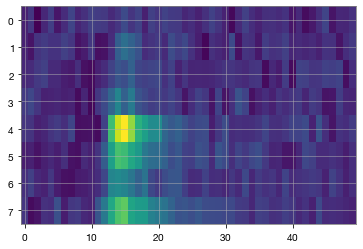

[1.443 1.401 1.359 1.317 1.275 1.233 1.191 1.149]


In [4]:
plt.imshow(ydata,aspect='auto')
plt.show()
print(freq)

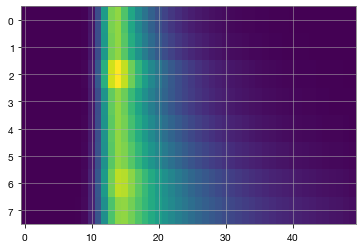

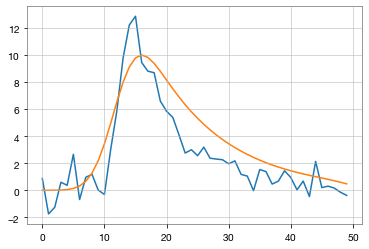

In [5]:
plt.imshow(scat_smear_8band(time,t0=15,tau1=9,dmerr=0,sigi=2,alpha=4,a1=25,a2=25,a3=30,a4=25,a5=25
                      ,a6=25,a7=27,a8=25),aspect='auto')
plt.figure()
plt.plot(ydata[7])
plt.plot(scat_pulse_smear(t=time,t0=15,tau1=9,dm=dm,dmerr=0,sigma=5,alpha=4,a=10,vi=freq[7]))
plt.show()

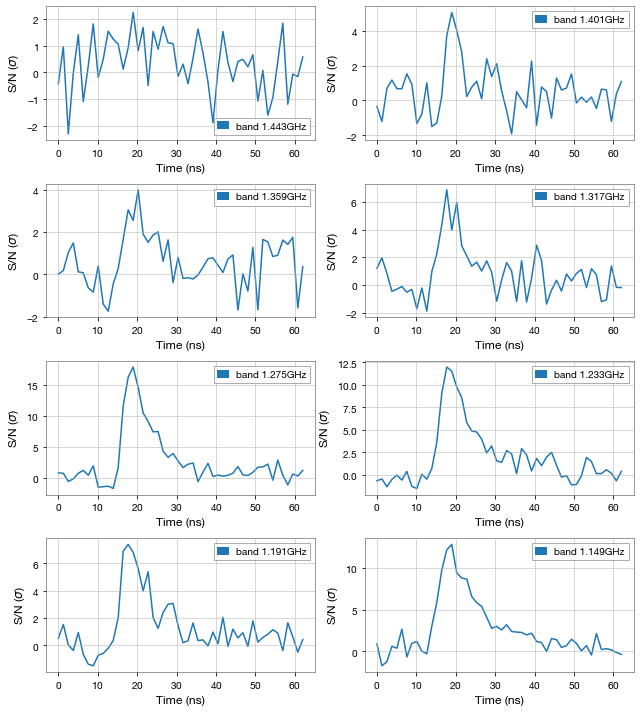

In [6]:
global priors1
amin=0
amax=30
taumax=30
priors1 = bilby.core.prior.PriorDict()
priors1["t0"]=bilby.core.prior.Uniform(name='t0', minimum=10*tsamp,maximum=20*tsamp)
priors1["tau1"]=bilby.core.prior.LogUniform(name='$\\tau$', minimum=0.005, maximum=taumax)
priors1["a1"]=bilby.core.prior.Uniform(name='a1', minimum=amin, maximum=amax)
priors1["a2"]=bilby.core.prior.Uniform(name='a2', minimum=amin, maximum=amax)
priors1["a3"]=bilby.core.prior.Uniform(name='a3', minimum=amin, maximum=amax)
priors1["a4"]=bilby.core.prior.Uniform(name='a4', minimum=amin, maximum=amax)
priors1["a5"]=bilby.core.prior.Uniform(name='a5', minimum=amin, maximum=amax)
priors1["a6"]=bilby.core.prior.Uniform(name='a6', minimum=amin, maximum=amax)
priors1["a7"]=bilby.core.prior.Uniform(name='a7', minimum=amin, maximum=amax)
priors1["a8"]=bilby.core.prior.Uniform(name='a8', minimum=amin, maximum=amax)
priors1["dmerr"]=bilby.core.prior.Uniform(name='dmerr', minimum=-10,maximum=10)
priors1["sigi"]=bilby.core.prior.Uniform(name='$\sigma$', minimum=0.05, maximum=5)
priors1["alpha"]=bilby.core.prior.Uniform(name='alpha',minimum=-5,maximum=20.0)
priors1["sigma"]=bilby.core.prior.Uniform(name='error',minimum=0.001,maximum=2)
plt.figure(figsize=(9,10))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(time,ydata[i],label="band "+"{0:.3f}".format(freq[i])+"GHz")
    #plt.plot(time,np.ones(len(time))*0.02,linestyle="--",label="rms from dynesty")
    plt.legend()
    plt.ylabel('S/N ($\sigma$)')
    plt.xlabel('Time (ns)')
plt.tight_layout()
#plt.savefig(o+"_p1_subbands.png",dpi=300)
plt.show()
plt.close()

In [7]:
likelihood = bilby.core.likelihood.GaussianLikelihood(x=time, y=ydata,func=scat_smear_8band, sigma=None)
# result = bilby.sampler.run_sampler(likelihood=likelihood, priors=priors1,sampler='dynesty'
#                                    ,npoints=150,clean=True,dlogz=0.1,outdir='outdir',label=out)
result=bilby.result.read_in_result(outdir='outdir/',label=out)

t0                 17.082518
tau1                5.865239
a1                  1.988815
a2                  4.621324
a3                  3.581014
a4                  5.763802
a5                 17.529765
a6                 12.069833
a7                  6.925007
a8                 12.056605
dmerr               2.003488
sigi                0.632017
alpha               4.261648
sigma               0.984381
log_likelihood   -560.263768
log_prior         -42.187296
dtype: float64


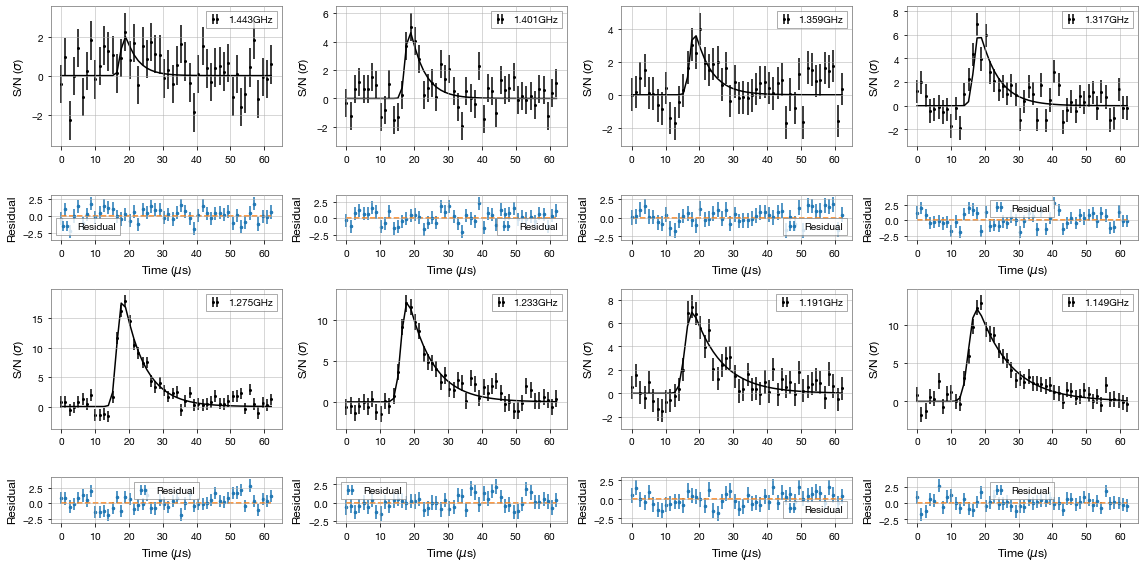

In [8]:
check_results(time,ydata,result,out)